# Regressão Softmax com dados do MNIST

O objetivo deste notebook é ilustrar o uso do mesmo código matricial desenvolvido para a classificação das Flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.


## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

## Funções já discutidas em notebooks anteriores

In [2]:
def predict(inputs, operation):
    outputs = operation(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

def getAccuracy(inputs, operation, targets):
    outputs = operation(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    predicts = predicts.data.numpy()
    targets = targets.numpy()
    
    accuracy = np.sum(predicts == targets) / float(targets.shape[0])
    return accuracy

## Carregamento dos dados do MNIST

In [3]:
dataset_dir = '/data/datasets/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega o conjunto de treinamento e de teste
train_dataset = MNIST(dataset_dir, train=True, transform=data_transform)
test_dataset = MNIST(dataset_dir, train=False, transform=data_transform)

print("Tamanho do dataset de treino:", len(train_dataset))
print("Tamanho do dataset de teste: ", len(test_dataset))

print("\nDimensões dos dados das imagens:", train_dataset[0][0].size())
print("Tipo dos dados das imagens:     ", type(train_dataset[0][0]))
print("Tipo das classes das imagens:   ", type(train_dataset[0][1]))

Tamanho do dataset de treino: 60000
Tamanho do dataset de teste:  10000

Dimensões dos dados das imagens: torch.Size([1, 28, 28])
Tipo dos dados das imagens:      <class 'torch.FloatTensor'>
Tipo das classes das imagens:    <class 'int'>


## Organizando e normalizando os dados

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras para testes.


In [4]:
n_samples_train = 500
n_samples_test  = 100

train_dataset.train_data = train_dataset.train_data[:n_samples_train]
train_dataset.train_labels = train_dataset.train_labels[:n_samples_train]
test_dataset.test_data = test_dataset.test_data[:n_samples_test]
test_dataset.test_labels = test_dataset.test_labels[:n_samples_test]

print('Amostras para treinamento:', len(train_dataset))
print('Amostras para validação:', len(test_dataset))

Amostras para treinamento: 500
Amostras para validação: 100


## Visualizando os dados

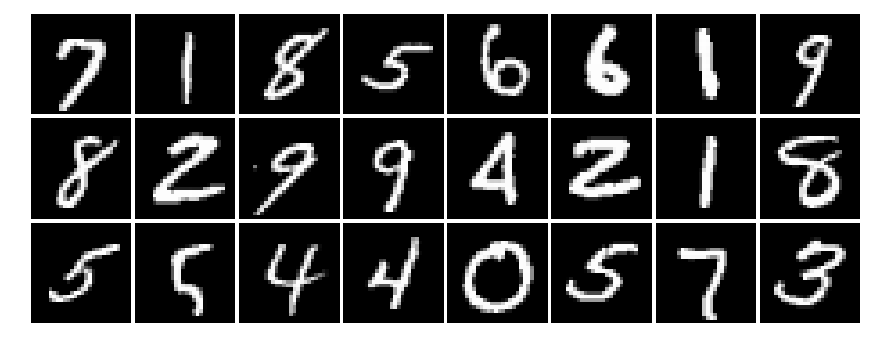

In [5]:
n_samples = 24

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=n_samples,
                                              shuffle=True)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Visualizando uma imagem com o matplotlib

class: 5


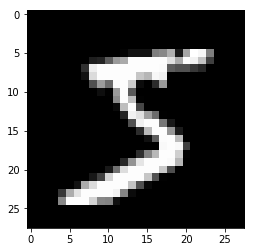

In [6]:
image, target = train_dataset[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Treinamento

### Inicialização dos parâmetros

In [7]:
epochs = 1000
learningRate = 0.5

# Cria um DataLoader de somente um batch
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=len(train_dataset),
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=len(test_dataset),
                                              shuffle=False)

# Pega todas as imagens de uma vez
input_data, targets_data = next(iter(train_dataloader))
# Transforma em vetor
input_data = input_data.view(-1, 28*28)

# Cria uma operação linear com entrada de tamanho 28*28 e saída de tamanho 10
# O objeto criado armazenará os pesos
linear = torch.nn.Linear(28*28, 10)

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Nosso otomizador será SDG
optimizer = torch.optim.SGD(linear.parameters(), lr=learningRate)

### Laço de treinamento dos pesos

In [8]:
losses = []

for i in range(epochs):
    # é precis zerar o gradiente antes de utilizá-lo novamente
    optimizer.zero_grad()
    
    # calcula a saída da operação linear
    output = linear(Variable(input_data))

    # calcula a perda
    loss = criterion(output, Variable(targets_data))

    # Faz o backpropagation para calcular os gradientes
    loss.backward()
    
    # Usa os gradientes para atualizar os pesos
    optimizer.step()
    
    losses.append(loss.data[0])
    
print('Final loss:', loss.data[0])

Final loss: 0.01573139615356922


## Visulizando gráfico de perda durante o treinamento

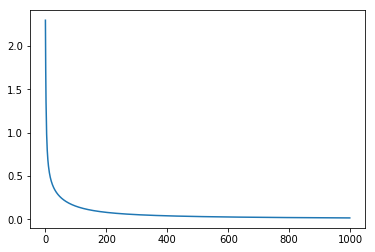

In [9]:
plt.plot(losses)

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de testes

In [10]:
def getAccuracy(inputs, operation, targets):
    outputs = operation(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    predicts = predicts.data.numpy()
    targets = targets.numpy()
    
    accuracy = np.sum(predicts == targets) / float(targets.shape[0])
    return accuracy

print('Training Accuracy: ', getAccuracy(input_data, linear, targets_data))

test_input, test_labels = next(iter(test_dataloader))
test_input = test_input.view(-1, 28*28)
print('Test Accuracy: ', getAccuracy(test_input, linear, test_labels))

Training Accuracy:  1.0
Test Accuracy:  0.84


## Matriz de confusão com dados de treinamento e teste

In [11]:
print('Matriz de confusão (Treino):')
display(pd.crosstab(predict(input_data, linear), targets_data.numpy()))

print('Matriz de confusão (Teste):')
display(pd.crosstab(predict(test_input, linear), test_labels.numpy()))

Matriz de confusão (Treino):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0
1,0,66,0,0,0,0,0,0,0,0
2,0,0,52,0,0,0,0,0,0,0
3,0,0,0,50,0,0,0,0,0,0
4,0,0,0,0,52,0,0,0,0,0
5,0,0,0,0,0,39,0,0,0,0
6,0,0,0,0,0,0,45,0,0,0
7,0,0,0,0,0,0,0,52,0,0
8,0,0,0,0,0,0,0,0,39,0


Matriz de confusão (Teste):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,8,0,0,0,0,0,0,0,0,0
1,0,14,0,0,0,0,0,0,0,0
2,0,0,7,0,0,1,1,1,0,0
3,0,0,1,11,0,2,0,0,0,0
4,0,0,0,0,11,1,0,0,0,0
5,0,0,0,0,0,2,0,0,1,0
6,0,0,0,0,1,0,9,0,0,0
7,0,0,0,0,0,1,0,12,0,2
8,0,0,0,0,0,0,0,0,1,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


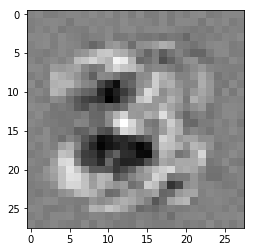

In [12]:
weights = linear.state_dict()['weight']
print('weights:', weights.shape)

bias = linear.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

## Visualizando os pesos de todas as classes

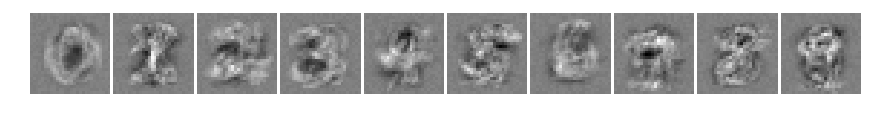

In [13]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Diagrama da regressão softmax com visualização dos pesos W

<img src="../figures/RegressaoSoftmaxArgmaxNMIST.png",width = 400>


### Exercício

Na configuração da figura acima, mostre os valores de z0 até z9, os valores das probabilidades y_oh_hat e o y_hat, quando a rede recebe como entrada a nona amostra que contém o manuscrito do dígito '4':

class: 4


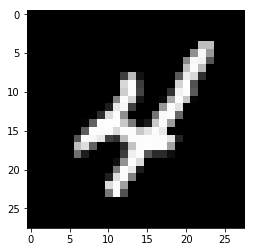

In [14]:
image, target = train_dataset[9]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Atividades

### Perguntas
1. Por que no treino, a acurácia é 100%, mas no teste foi de 84,5%
2. Por que no treino, a acurácia é 100%, porém a função de perda final não é zero, mas sim 0,015 ?
3. O que se deve fazer para que a avaliação no conjunto de teste seja melhorado?

## Conclusões sobre os experimentos deste notebook
